# Финальный проект: App "Ненужные вещи"

## Материалы
* [Презентация](https://disk.yandex.ru/i/umWSyOJsOHaZHw)
* [Дашборд](https://public.tableau.com/views/Dashboardfinalproject_16610932738300/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link)

## Содержание

1. [Цели и описание проекта, плана работы](#step1)
2. [Предобработка данных](#step2)
3. [Исследовательский анализ данных](#step3)
4. [Ответы на вопросы заказчика](#step4)
5. [Проверка статестических гипотез](#step5)
6. [Выводы](#step6)
7. [Рекомендации](#step7)

### Цель проекта

Выделение групп пользователей на основе поведения

### Описание проекта<a id="step1"></a>

Выбрать методику сегментации пользователей и ответить на вопросы заказчика в разрезе выделенных групп

* Пользователи какой группы склонны часто возвращаться в мобильное приложение (Retention rate)?
* Пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?
* Как различается время между распространенными событиями пользователей из разных групп?

Проверьте статистические гипотезы:

* Некоторые пользователи установили приложение по ссылке из yandex, другие — из google. Проверьте гипотезу: две эти группы демонстрируют разную конверсию в просмотры контактов.
* Сформулируйте собственную гипотезу. Дополните её нулевой и альтернативной гипотезами. Проведите статистический тест.

По итогам исследования подготовить презентацию.

### План работы

* выгрузка данных
* предобработка данных
* исследовательский анализ
* расчет метрик и показателей
* сегментация пользователей на основе этих показателей
* анализ групп пользователей
* расчет ключевых метрик
* ответы на воприсы исследования
* выдвижение и проверка гипотез
* выводы и рекомендации
* презентация


## Предобработка данных<a id="step2"></a>

Подгрузим библеотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy import stats as st
import seaborn as sns
from datetime import timedelta, datetime
import math as mth
from plotly import graph_objects as go
import plotly.express as px
import plotly.graph_objs as go
from matplotlib import style
import os

Загрузим данные.

In [2]:
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

Посмотрим на датасет `mobile_sourсes`.

In [3]:
mobile_sourсes.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


Датасет **mobile_sources.csv** содержит колонки:

    `userId` — идентификатор пользователя
    `source` — источник, с которого пользователь установил приложение

In [4]:
# пререименуем столбцы
mobile_sourсes = mobile_sourсes.rename({'userId': 'user_id'}, axis=1)

In [5]:
# проверим на наличие дубликатов
mobile_sourсes.duplicated().sum()

0

In [6]:
# проверим на пропуски
mobile_sourсes.isna().sum()

user_id    0
source     0
dtype: int64

Выведем информацию по датасету

In [7]:
mobile_sourсes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  4293 non-null   object
 1   source   4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [8]:
mobile_sourсes['user_id'].nunique()

4293

In [9]:
mobile_sourсes.groupby('source').count()

,user_id
source,
google,1129
other,1230
yandex,1934


Мы загрузили датасет `mobile_sourсes`. Переименовали столбец и проверили на дубликаты. В нем нет нулевых значений и пропусков. В столбце `user_id` все значения уникальны (всего 4293), а в столбце `source` их только 3 - google, other и yandex.

Посмотрим на датасет `mobile_dataset`.

In [10]:
mobile_dataset.head()

,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Датасет **mobile_dataset.csv** содержит колонки:

    `event.time` — время совершения
    `event.name` — название события
    `user.id` — идентификатор пользователя

In [11]:
# пререименуем столбцы
mobile_dataset = mobile_dataset.rename({'event.time': 'event_time', 
                                        'event.name': 'event_name', 
                                        'user.id': 'user_id'}, 
                                       axis=1)

In [12]:
# проверим на наличие дубликатов
mobile_dataset.duplicated().sum()

0

In [13]:
# проверим на пропуски
mobile_dataset.isna().sum()

event_time    0
event_name    0
user_id       0
dtype: int64

Выведем информацию по `mobile_dataset`.

In [14]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [15]:
# преобразуем дату
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time']).dt.round('1S')
mobile_dataset

,event_time,event_name,user_id
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c
...,...,...,...
74192,2019-11-03 23:53:30,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74193,2019-11-03 23:54:00,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9
74194,2019-11-03 23:56:57,search_1,20850c8f-4135-4059-b13b-198d3ac59902
74195,2019-11-03 23:57:06,tips_show,28fccdf4-7b9e-42f5-bc73-439a265f20e9


In [16]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


In [17]:
print('Минимальная дата -', mobile_dataset['event_time'].min())
print('Максимальная дата -', mobile_dataset['event_time'].max())

Минимальная дата - 2019-10-07 00:00:00
Максимальная дата - 2019-11-03 23:58:13


Мы загрузили датасет `mobile_dataset`. Переименовали столбецы и проверили на дубликаты. В нем нет нулевых значений и пропусков. Датасет содержит временной промежуток с 00:00 07-10-2019 по 23:58 03-11-2019.

## Исследовательский анализ данных<a id="step3"></a>

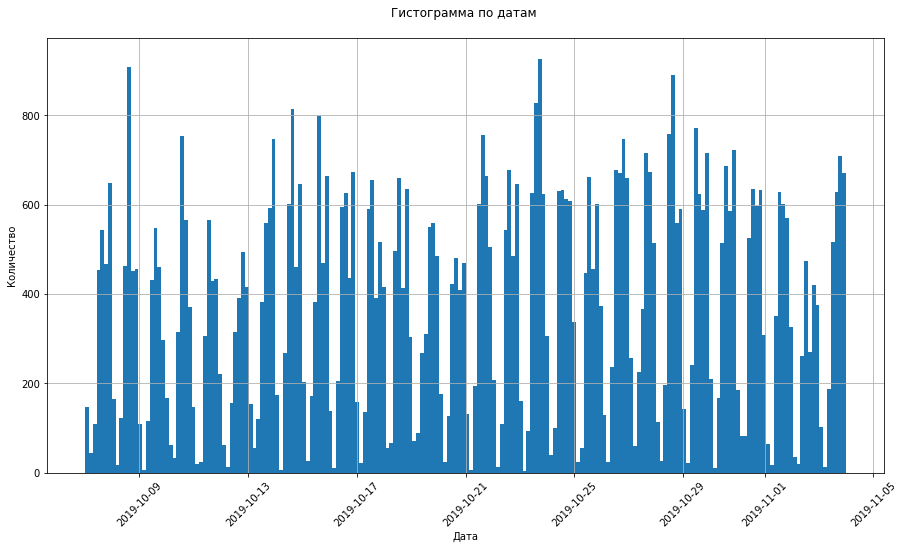

In [18]:
# Построим гистограмму по дате и времени
plt.figure(figsize=(15,8))
mobile_dataset['event_time'].hist(bins=200)

plt.title('Гистограмма по датам \n')
plt.ylabel('Количество')
plt.xlabel('Дата')
plt.xticks(rotation=45)
plt.show()

На графике прослеживаются суточные и недельные ритмы.

Посмотрим на уникальные значения столбца `event_name` и отсортируем.

In [19]:
mobile_dataset['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

Расшифровки событий:

    `advert_open` — открытие карточки объявления
    `photos_show` — просмотр фотографий в объявлении
    `tips_show` — пользователь увидел рекомендованные объявления
    `tips_click` — пользователь кликнул по рекомендованному объявлению
    `contacts_show` и `show_contacts` — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления
    `contacts_call` — пользователь позвонил по номеру телефона на карточке объявления
    `map` — пользователь открыл карту размещенных объявлений
    `search_1` — `search_7` — разные события, связанные с поиском по сайту
    `favorites_add` — добавление объявления в избранное

В столбце есть неявные дубликаты: `contacts_show` и `show_contacts`. Объединим эти события переименовав одно из них.
Так же объединим все search с 1 по 7 в один searchs.

In [20]:
mobile_dataset_unite = mobile_dataset.replace({'event_name':{'show_contacts':'contacts_show', 
                                                             'search_1':'searchs',
                                                             'search_2':'searchs',
                                                             'search_3':'searchs',
                                                             'search_4':'searchs',
                                                             'search_5':'searchs',
                                                             'search_6':'searchs',
                                                             'search_7':'searchs'}})

Сгруппируем заново и отсорируем.

In [21]:
mobile_dataset_unite['event_name'].value_counts()

tips_show        40055
photos_show      10012
searchs           6784
advert_open       6164
contacts_show     4529
map               3881
favorites_add     1417
tips_click         814
contacts_call      541
Name: event_name, dtype: int64

Мы видем, что самое популярное событие - `photos_show` (10012 кликов). А наименее популярное событие - `contacts_call` (541 клик).
Событие `tips_show` мы не учитываем, т.к. оно не зависит от действий пользователя.

Выделим сессии относительно таймаута равному 30 минутам. Общепринятая практика. Так как тайм-аут сеанса по умолчанию в Яндекс.Метрике и в Google Analytics равен 30 минутам.

In [22]:
# отсортируем датасет
mobile_dataset_unite = mobile_dataset_unite.sort_values(['user_id', 'event_time'])

g = ((mobile_dataset_unite.groupby('user_id')['event_time']).diff() > pd.Timedelta('30min')).cumsum()

# создадим новый столбец сесcий
mobile_dataset_unite['session_id'] = mobile_dataset_unite.groupby(['user_id', g], sort=False).ngroup() + 1
mobile_dataset_unite

,event_time,event_name,user_id,session_id
805,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1
806,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1
809,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1
820,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1
830,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1
...,...,...,...,...
72584,2019-11-03 15:51:24,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368
72589,2019-11-03 15:51:58,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368
72684,2019-11-03 16:07:41,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368
72688,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368


In [23]:
# сгруппируем по сессии и определим продолжительность каждой сессии

data_duration = (mobile_dataset_unite.groupby('session_id')['event_time']
                                     .agg(lambda x: max(x) - min(x))
                                     .to_frame()
                                     .rename(columns={'event_time': 'duration'}))
# округлим до секунды                                    
data_duration['duration'] = data_duration['duration'] / np.timedelta64(1, 's')
data_duration

,duration
session_id,
1,596.0
2,507.0
3,899.0
4,758.0
5,1521.0
...,...
10364,0.0
10365,974.0
10366,296.0


Построим гистограмму распределения продолжительности сессии

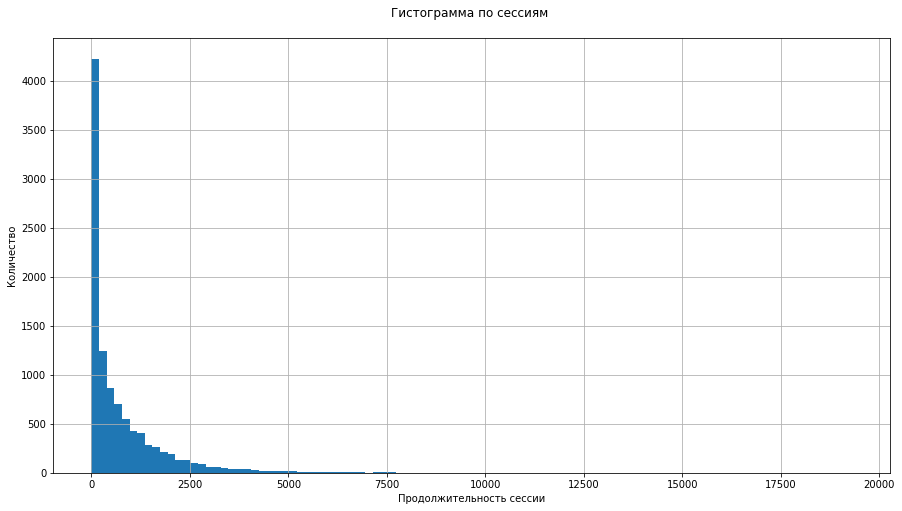

In [24]:
plt.figure(figsize=(15,8))
data_duration['duration'].hist(bins=100)
plt.title('Гистограмма по сессиям \n')
plt.ylabel('Количество')
plt.xlabel('Продолжительность сессии')

plt.show()

Секунды, проведённые пользователями в приложении, имеют экспоненциальное распределение с пиком в районе нуля. Надо поподробней разобраться, почему так много очень коротких сессий. Здесь одна из точек раста использования нашего приложения.

Сесии меньше 2 секунд посчитаем за ошибочные, т. к. за это время невозможно полноценно воспользоваться программой. Скорее всего здесь речь идет о каком-то сбое. Принимаем решение удалить их. Так же необходимо удалить "длинный хвост" сессий. Для уточнения его границы построим ящик с усами.

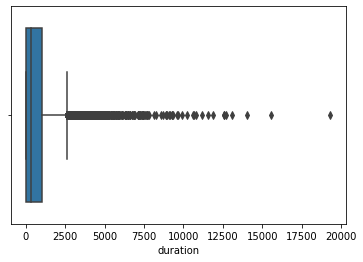

In [25]:
# построим ящик с усами
sns.boxplot(x=data_duration['duration']);

Мы видим, что сессии продолжительностью более 2500 секунд тоже можно удалить.

Посчитаем, какое количество данных мы собираемся удалить.

In [26]:
size2 = len(data_duration.query('duration < 2'))
size2500 = len(data_duration.query('duration > 2500'))
size_all = len(data_duration)

print('Размер данных где сессии < 2 секунд - {}.   Это {:.1%} от общего количества'.format(size2, size2/size_all) )
print('Размер данных где сессии > 2500 секунд- {}.   Это {:.1%} от общего количества'.format(size2500, size2500/size_all) )
print('Общее количество сессий', size_all)
print('Мы удаляем {} сессий.  Это {:.1%} от общего количества'.format(size2+size2500, (size2+size2500)/size_all) )

Размер данных где сессии < 2 секунд - 2181.   Это 21.0% от общего количества
Размер данных где сессии > 2500 секунд- 723.   Это 7.0% от общего количества
Общее количество сессий 10368
Мы удаляем 2904 сессий.  Это 28.0% от общего количества


Почистим датафрейм сессий применив маску фильтрации.

In [27]:
data_duration_clin = data_duration.query('duration >= 2 and duration <= 2500').reset_index()
# создадим маску фильтрации
mask = mobile_dataset_unite['session_id'].isin(data_duration_clin['session_id'])
# применим маску к датафрейму
mobile_dataset_clean = mobile_dataset_unite[mask]
# отсортируем
mobile_dataset_clean = mobile_dataset_clean.sort_values(['session_id', 'event_time']).reset_index(drop=True)
mobile_dataset_clean

,event_time,event_name,user_id,session_id
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1
...,...,...,...,...
52777,2019-11-03 15:51:24,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368
52778,2019-11-03 15:51:58,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368
52779,2019-11-03 16:07:41,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368
52780,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368


Расчитаем длительность каждого события.

In [28]:
mobile_dataset_clean['delta'] = [0]*len(mobile_dataset_clean)

for i in range(1, len(mobile_dataset_clean)):
    
    if mobile_dataset_clean.loc[i-1,'session_id'] == mobile_dataset_clean.loc[i,'session_id']:
        delta = mobile_dataset_clean.loc[i,'event_time'] - mobile_dataset_clean.loc[i-1,'event_time']
        mobile_dataset_clean.loc[i-1,'delta'] = delta.total_seconds()

In [29]:
mobile_dataset_clean

,event_time,event_name,user_id,session_id,delta
0,2019-10-07 13:39:46,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,45
1,2019-10-07 13:40:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,35
2,2019-10-07 13:41:06,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,135
3,2019-10-07 13:43:21,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,130
4,2019-10-07 13:45:31,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,12
...,...,...,...,...,...
52777,2019-11-03 15:51:24,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,34
52778,2019-11-03 15:51:58,contacts_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,943
52779,2019-11-03 16:07:41,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,37
52780,2019-11-03 16:08:18,tips_show,fffb9e79-b927-4dbb-9b48-7fd09b23a62b,10368,7


Посмотрим статистику по сессиям.

In [30]:
md_stat = ( mobile_dataset_clean.groupby('event_name')['delta']
                                .agg(['sum', 'count', 'mean', 'median', 'min', 'max']))
md_stat                                

,sum,count,mean,median,min,max
event_name,,,,,,
advert_open,158422,4556,34.772169,7,0,1754
contacts_call,55243,442,124.984163,13,0,1700
contacts_show,281892,3007,93.745261,17,0,1787
favorites_add,84527,908,93.091410,36,0,1765
map,266132,2843,93.609567,51,0,1692
photos_show,856492,8108,105.635422,45,0,1798
searchs,537571,5724,93.915269,27,0,1795
tips_click,24917,570,43.714035,9,0,1010
tips_show,2801533,26624,105.225849,57,0,1796


Заменим нули на медианные значения.

In [31]:
# напишем цикл
for i in md_stat.index:
        mobile_dataset_clean['delta'].replace(to_replace=0, value = md_stat.loc[i,'median'], inplace = True)

Еще раз посмотрим на статистику.

In [32]:
md_stat = ( mobile_dataset_clean.groupby('event_name')['delta']
                                .agg(['sum', 'count', 'mean', 'median', 'min', 'max'])
                                .sort_values('mean', ascending=False))
md_stat 

,sum,count,mean,median,min,max
event_name,,,,,,
contacts_call,56650,442,128.167421,13,1,1700
photos_show,870233,8108,107.330168,45,1,1798
tips_show,2830373,26624,106.309082,57,1,1796
contacts_show,286246,3007,95.193216,17,1,1787
searchs,542555,5724,94.785989,27,1,1795
favorites_add,85738,908,94.425110,36,1,1765
map,268372,2843,94.397467,51,1,1692
tips_click,25218,570,44.242105,9,1,1010
advert_open,160326,4556,35.190079,7,1,1754


В среднем, самые продолжительные события: `contacts_call` - 128.2 секунд, `photos_show` - 107.3,`tips_show` - 106.3 секунды. Самые скоротечные: `tips_click` - 44.2, `advert_open` - 35.2 секунды.

Найдем общее и среднее время проведенное пользователями в приложении. 

In [33]:
print('Общее время проведенное пользователями в приложении {:.5} часов'.format(md_stat['sum'].sum()/3600))

print('Было совершено {} события со средней продолжительностью {:.3} секунды'
      .format(md_stat['count'].sum(), md_stat['mean'].mean() ))

Общее время проведенное пользователями в приложении 1423.8 часов
Было совершено 52782 события со средней продолжительностью 88.9 секунды


**Разделим наших пользователей на три группы.**

* Группа data_tips_click - те, кто пользовался рекомендованными объявлениями `tips_click`;
* Группа data_map_click - те, кто использовал `map`;
* Группа data_search_click - остальные, кто использовал `search`. 

In [34]:
# создадим список уникальных user_id совершивших tips_click
filter_tips_click = mobile_dataset_clean.query('event_name == "tips_click"')['user_id'].unique()
# создадим маску
mask = mobile_dataset_clean['user_id'].isin(filter_tips_click)
# применим маску
data_tips_click, data_no_tips_click = mobile_dataset_clean[mask], mobile_dataset_clean[~mask]

# выделим группу кто пользуется картой при просмотре объявлений
# создадим список
map_click = data_no_tips_click.query('event_name == "map"')['user_id'].unique()
# создадим маску
mask = data_no_tips_click['user_id'].isin(map_click)
# применим маску
data_map_click, data_search_click = data_no_tips_click[mask], data_no_tips_click[~mask]

In [35]:
print('Мы разбили посетителей сайта на группы по: {}, {} и {} уникальных пользователей'.format(
                                                            data_tips_click['user_id'].nunique(),
                                                            data_map_click['user_id'].nunique(),
                                                            data_search_click['user_id'].nunique())
                                                             )

Мы разбили посетителей сайта на группы по: 263, 1171 и 2551 уникальных пользователей


## Ответим на вопросы заказчика:<a id="step4"></a>

* Пользователи какой группы склонны часто возвращаться в мобильное приложение (Retention rate)?
* Пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?
* Как различается время между распространенными событиями пользователей из разных групп?

#### Пользователи какой группы склонны часто возвращаться в мобильное приложение (Retention rate)?
Расчитаем Retention rate.

Для расчета нам необходимо найти дату начала использования приложения.

In [36]:
# Напишем функцию для нахождения даты начала использования приложения
def first_date(mobile_data):
    
  # отсортируем датафрейм и представим event_timе в формте даты
    mobile_data = mobile_data.sort_values(['user_id', 'event_time'])
    mobile_data['event_time'] = mobile_data['event_time'].dt.date
    mobile_data['event_time'] = pd.to_datetime(mobile_data['event_time'])
    #mobile_data = mobile_data.reset_index(drop=True)
 
    # сгруппируем по сессиям и посмотрим первые значения
    # найдем дату первого использования приложения
    data_fr_date = mobile_data.groupby('user_id').agg({'event_time': 'first'})#.reset_index()
    data_fr_date = data_fr_date.rename({'event_time':'first_date'}, axis=1)

    # объединим данные
    mobile_data = mobile_data.merge(data_fr_date, on='user_id', how='left')
    
    return mobile_data

Напишем функцию для расчета Retention rate.

In [37]:
def Retention_Table_heatmap (data):

    # посчитаем и добавим столбец lifetime
    # преобразуем даты в недели
    data['event_time'] = data['event_time'].astype('datetime64[W]')
    data['first_date'] = data['first_date'].astype('datetime64[W]')
    data['lifetime'] = data['event_time'] - data['first_date']
    
    # сгруппируем
    group = data.groupby(['first_date', 'lifetime'])
    cohort_data = group['user_id'].size().reset_index()
    
    # создадим сводную таблицу
    cohort_counts = cohort_data.pivot(index='first_date', columns='lifetime', values='user_id')
    cohort_counts
    # берем первый столбец за базу
    base = cohort_counts['0 days']
    
    # применим метод divide разделив на основание
    retention = cohort_counts.divide(base, axis=0).round(3)
    
    # построим тепловую карту
    plt.figure(figsize=(8,5))
    plt.title('Retention Table \n')
    ax = sns.heatmap(data=retention, annot=True, fmt='.1%', vmin=0.0, vmax=0.5,cmap='Reds')
    ax.set_yticklabels(retention.index)
    ax.set_xticklabels(retention.columns)
    
    plt.show()

#### Посмотрим на Retention_Table_heatmap наших данных.


Retention_Table_heatmap для всех пользователей


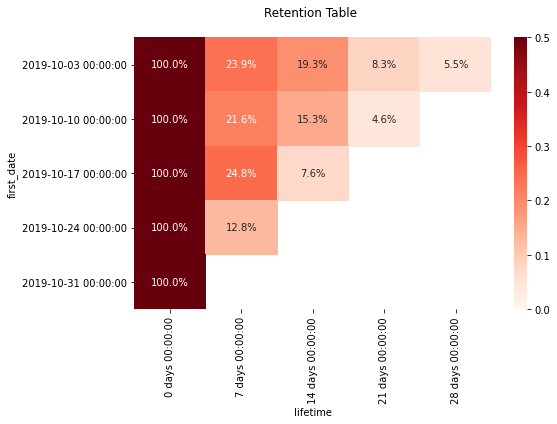


Retention_Table_heatmap для пользующихся рекомендациями - tips_click 


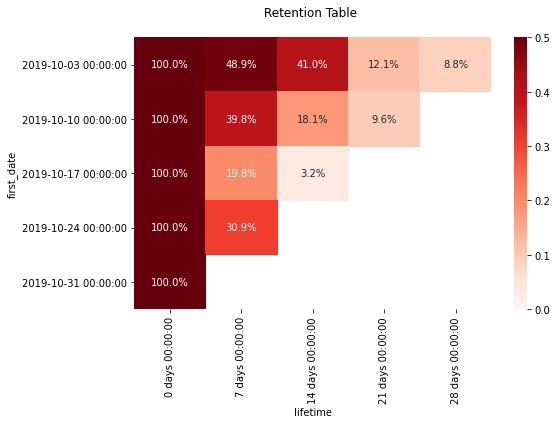


Retention_Table_heatmap для использующих карту - map_click


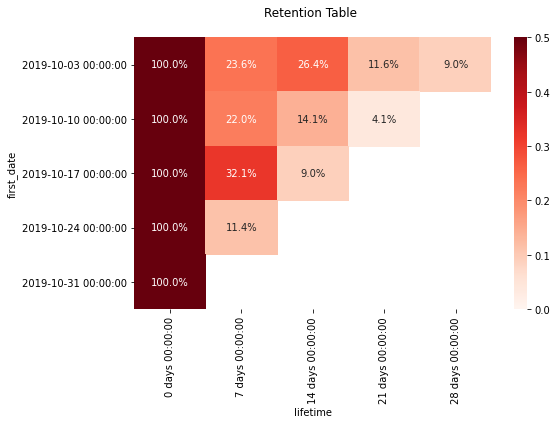


Retention_Table_heatmap для пользующихся только просмотром - search_click


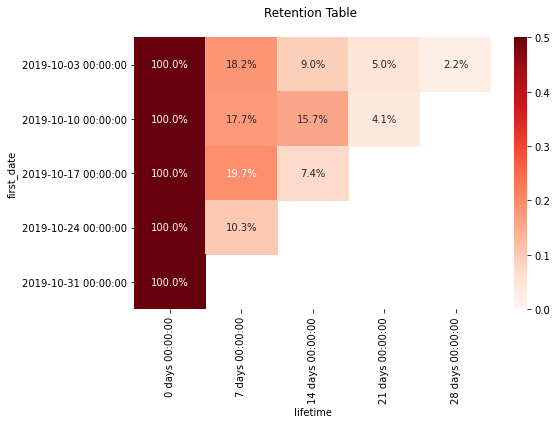

In [38]:
# создадим списки для работы в цикле
baza = [mobile_dataset_clean, data_tips_click, data_map_click, data_search_click]
baza_name = (['всех пользователей', 'пользующихся рекомендациями - tips_click ', 
              'использующих карту - map_click', 'пользующихся только просмотром - search_click'])

# напишем цикл
for i,j in zip(baza, baza_name):
    
    print()
    print('Retention_Table_heatmap для', j)
    Retention_Table_heatmap(first_date(i))

Мы видим, что у клиентов пользующихся рекомендованными объявлениями `tips_click`, *Retention rate* выше, чем у других групп.
Самый маленикий *Retention rate* у клиентов использующих только поиск `search`.

#### Пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?

Посчитаем конверсию в целевое действие.

In [39]:
# напишем цикл
for i,j in zip(baza, baza_name):

    c_s = i.query('event_name == "contacts_show"')['user_id'].nunique()
    total = len(i.groupby('user_id').count())
    
    print('В группе {} всего {} пользователей. {} из них совершили целевое действие.'.format(j, total, c_s ))
    print('Конверсия составила {:.1%}'.format(c_s/total))
    print()

В группе всех пользователей всего 3985 пользователей. 849 из них совершили целевое действие.
Конверсия составила 21.3%

В группе пользующихся рекомендациями - tips_click  всего 263 пользователей. 69 из них совершили целевое действие.
Конверсия составила 26.2%

В группе использующих карту - map_click всего 1171 пользователей. 198 из них совершили целевое действие.
Конверсия составила 16.9%

В группе пользующихся только просмотром - search_click всего 2551 пользователей. 582 из них совершили целевое действие.
Конверсия составила 22.8%



Мы видим что у пользователей из группы `tips_click`конверсия самая высокая и составляет 26.2%. Самая низкая конверсия у группы `map_click` - 16.9%. 

#### Как различается время между распространенными событиями пользователей из разных групп?

In [40]:
# напишем цикл
for i,j in zip(baza, baza_name):
    
    mdc_pt = (pd.pivot_table(i, columns ='event_name', values = 'delta', aggfunc='mean',).T
                .sort_values('delta', ascending=False)
                )
    print()
    print('Таблица распределения событий в группе {} по времени'.format(j))
    display(mdc_pt.round(1))
    print()
    


Таблица распределения событий в группе всех пользователей по времени


,delta
event_name,
contacts_call,128.2
photos_show,107.3
tips_show,106.3
contacts_show,95.2
searchs,94.8
favorites_add,94.4
map,94.4
tips_click,44.2
advert_open,35.2




Таблица распределения событий в группе пользующихся рекомендациями - tips_click  по времени


,delta
event_name,
contacts_show,137.6
photos_show,120.5
tips_show,116.9
map,108.0
searchs,70.8
advert_open,47.5
tips_click,44.2
favorites_add,40.6




Таблица распределения событий в группе использующих карту - map_click по времени


,delta
event_name,
photos_show,118.6
contacts_show,100.7
tips_show,99.5
map,92.8
searchs,61.3
favorites_add,49.3
advert_open,27.0




Таблица распределения событий в группе пользующихся только просмотром - search_click по времени


,delta
event_name,
contacts_call,128.2
tips_show,110.3
favorites_add,108.1
searchs,107.4
photos_show,107.0
contacts_show,86.8
advert_open,49.3


Изучая среднее время в трех группах видно, насколько по разному ведут себя покупатели. Если в группе tips_click наибольшее время приходится на `contacts_show` (137.6) и `photos_show` (120.5), то в группе map_click это `photos_show` (118.6) и `contacts_show` (100.7). Группа search_click координально от них отличается. Здесь в топе `contacts_call` (128.2) и `favorites_add` (108.1). В этой группе активно пользуются добавлением в избранное при просмотре объявлений. (Действие `tips_show` мы не берем в расчет, т.к. оно не зависит от действий посетителя). Наименее продолжительные действия в группе tips_click - `favorites_add` (40.6),а в группах map_click и search_click - `advert_open` (27.0) и  (49.3) соответственно.  

## Проверка статестических гипотез<a id="step5"></a>

**Проверим первую гипотезу:** 

пользователи установившие приложение по ссыке из `yandex` и пользователи установившими приложение из `google` демонстрируют разную конверсию в `contacts_show` (в просмотры контыктов). 

Cформулируем гипотезы:

Нулевая гипотеза - у пользователей установивших yandex и пользователей установивших google конверсия в просмотры одинаковая.
Альтернативная гипотеза - группы демонстрируют разную конверсию в просмотры контактов.

Для начала объединим два датафрейма с данными и разделим на 2 части.

In [41]:
data = mobile_dataset_clean.merge(mobile_sourсes, on='user_id', how='left')

data_yandex = data.query('source == "yandex"')
data_google = data.query('source == "google"')

Посчитаем доли.

In [42]:
yandex_total = len(data_yandex.groupby('user_id')['event_name'].count())
yandex_fact = len(data_yandex.query('event_name == "contacts_show"').groupby('user_id')['event_name'].count())

google_total = len(data_google.groupby('user_id')['event_name'].count())
google_fact = len(data_google.query('event_name == "contacts_show"').groupby('user_id')['event_name'].count())

print(yandex_fact, google_fact, yandex_total, google_total)

417 236 1797 1045


Напишем функцию для рассчета.

In [43]:
def count_pvalue(fact1, fact2, total1, total2):
    
    # пропорция событий в первой группе:
    p1 = fact1/total1
    # пропорция событий во второй группе:
    p2 = fact2/total2 
    # пропорция событий в комбинированном датасете:
    p_comb = (fact1 + fact2) / (total1 + total2)
    # разница пропорций в датасетах
    delta = p1 - p2  
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = delta / mth.sqrt(p_comb * (1 - p_comb) * (1/total1 + 1/total2))
    
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    # считаем p-value
    p_value = (1 - distr.cdf(abs(z_value)))*2

    print('p-значение: ', p_value)
    
    # критический уровень статистической значимости
    alpha = 0.05
    
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между группами есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными')
    
    print()
    print('Конверсия первой группы {:.2%}'.format(fact1/total1))
    print('Конверсия второй группы {:.2%}'.format(fact2/total2))      

In [44]:
count_pvalue(yandex_fact, google_fact, yandex_total, google_total)

p-значение:  0.7040757644231586
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Конверсия первой группы 23.21%
Конверсия второй группы 22.58%


Вывод: у пользователей установивших yandex и пользователей установивших google конверсия в просмотры одинаковая.

**Проверим вторую гипотезу:**

Одни пользователи совершают действия `favorites_add`, другие — его не совершают. Проверяем гипотезу: конверсия в просмотры контактов различается у этих двух групп.

Сформулируем гипотезы.

Нулевая гипотеза - у пользователей совершающих событие favorites_add и у пользователей не совершающих это действие конверсия в просмотры одинаковая.

Альтернативная гипотеза - конверсия у этих групп разная.

Посчитаем доли.

In [45]:
# создадим список уникальных user_id совершивших favorites_add
filter_favorites_add = data.query('event_name == "favorites_add"')['user_id'].unique()
# создадим маску
mask = data['user_id'].isin(filter_favorites_add)
# применим маску и создадим 2 датафрейма
data_favorites_add, data_no_favorites_add = mobile_dataset_clean[mask], mobile_dataset_clean[~mask]

favorites_total = len(data_favorites_add.groupby('user_id').count())
favorites_fact = len(data_favorites_add.query('event_name == "contacts_show"').groupby('user_id').count())

no_favorites_total = len(data_no_favorites_add.groupby('user_id').count())
no_favorites_fact = len(data_no_favorites_add.query('event_name == "contacts_show"').groupby('user_id').count())

print(favorites_fact, no_favorites_fact, favorites_total, no_favorites_total)

99 750 287 3698


In [46]:
count_pvalue(favorites_fact, no_favorites_fact, favorites_total, no_favorites_total)

p-значение:  1.4703519291003886e-08
Отвергаем нулевую гипотезу: между группами есть значимая разница

Конверсия первой группы 34.49%
Конверсия второй группы 20.28%


Вывод: у пользователей совершающих событие `favorites_add` и у пользователей не совершающих это действие конверсия в просмотры разная.

## Выводы<a id="step6"></a>

#### В начале проекта мы загрузили данные и подготовили их.

* Заменили названия столбцов
* Проверили на пропуски и нулевые значения
* Проверили на наличие дубликатов и объединили неявные дубликаты.

#### Изучили и проверили данные.

* Всего 4293 уникальных пользователя
* Временной отрузок событий с 00:00 07.10.2019 по 23:58 03.11.2019
* На гистограмме четко прослеживаются суточные и недельные ритмы.
* Самое популярное событие - `photos_show` (10012 кликов). А наименее популярное событие - `contacts_call` (541 клик).
* Выделили сессии относительно таймаута равному 30 минутам.
* Построили гистограмму распределения продолжительности сессий. Обнаружили, что очень много сессий находится в районе нуля. Сессии менее 2 секунд посчитали за ошибочные и отсекли их. Так же удалили сессии длиннее 2500 секунд. Всего было удалено 28% от общего числа сессий.
* Расчитали длительность каждого события. В среднем, самые продолжительные события - `contacts_call` (128.2 секунды), `photos_show` (107.3) и `contacts_show` (95.2 секунд). (Событие `tips_show` мы не учитываем, т.к. оно не зависит от действий пользователя). А самые скоротечные события - `map` (94.4), `tips_click` (44.2) и  `advert_open` (35.2 секунды).
* Подсчитали, что общее время проведенное пользователями в приложении 1423.8 часов. Было совершено 52782 событий со средней продолжительностью 88.9 секунды.
* Разделили пользователей на три группы.
    * Группа data_tips_click - те, кто пользовался рекомендованными объявлениями `tips_click`;
    * Группа data_map_click - те, кто использовал `map`;
    * Группа data_search_click - остальные, кто использовал `search`.

#### Ответили на вопросы заказчика

* Пользователи какой группы склонны часто возвращаться в мобильное приложение (Retention rate)?
    * Построили тепловую карту для наших групп и выяснили, что у клиентов пользующихся рекомендованными объявлениями `tips_click`, *Retention rate* выше, чем у других групп. Самый маленикий *Retention rate* у клиентов использующих только поиск `search`.
* Пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?
    * Посчитали конверсию и мы видили, что у пользователей из группы tips_clickконверсия самая высокая и составляет 26.2%. Самая низкая конверсия у группы map_click - 16.9%.
* Как различается время между распространенными событиями пользователей из разных групп?
    * Построили таблицы распределения событий в группах по времени и увидели, насколько по разному ведут себя покупатели. Если в группе tips_click наибольшее время приходится на `contacts_show` (137.6) и `photos_show` (120.5), то в группе map_click это `photos_show` (118.6) и `contacts_show` (100.7). Группа search_click координально от них отличается. Здесь в топе `contacts_call` (128.2) и `favorites_add` (108.1). В этой группе активно пользуются добавлением в избранное при просмотре объявлений. (Действие `tips_show` мы не берем в расчет, т.к. оно не зависит от действий посетителя). Наименее продолжительные действия в группе tips_click - `favorites_add` (40.6),а в группах map_click и search_click - `advert_open` (27.0) и  (49.3) соответственно.  

#### Проверили статестические гипотезы.

* Гипотеза первая: пользователи установившие приложение по ссыке из `yandex` и пользователи установившими приложение из `google` демонстрируют разную конверсию в `contacts_show` (в просмотры контыктов).
    * Провели Z-тест и выяснили, что у пользователей установивших `yandex` и пользователей установивших `google` конверсия в просмотры одинаковая.
* Гипотеза вторая: одни пользователи совершают действия `favorites_add`, другие — его не совершают. Проверяем гипотезу: конверсия в просмотры контактов различается у этих двух групп.
    * Провели Z-тест и увидели что у пользователей совершающих событие `favorites_add` и у пользователей не совершающих это действие конверсия в просмотры разная.

## Рекомендации<a id="step7"></a>

* Обратить внимание на большое количество ошибочных сессий (меньше 2 секунд)- 28%. Возможна некорректная работа браузера и т.п. Здесь одна из точек роста приложения.
* Улучшить систему рекомендательных объявлений, т.к. крайне мало переходов от `tips_show` к `tips_click`.
* Добавить событие клика по карточке товара, чтобы иметь представление, как событие клика влияет на целевое действие.